In [1]:
import cPickle as pickle
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import keras.callbacks
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import coremltools
import signal
import download

%matplotlib inline

Using TensorFlow backend.


## Downloading the Jukebox Detection Dataset

In [17]:
download \
    .maybe_download_and_extract('https://s3.amazonaws.com/tt-cocoaheads-demo/jukebox-detector-data.tar.gz', '.')

- Download progress: 100.0%()
Download finished. Extracting files.
Done.


In [3]:
def count_samples(sample_dir):
    count = 0
    for root, dirnames, filenames in os.walk(sample_dir):
        for filename in filenames:
            basename, ext = os.path.splitext(filename)
            if ext.lower() in ['.jpg', '.png', '.jpeg']:
                count+=1
    return count

## Compiling Inception V3 for Fine-Tuning

In [4]:
# Set the requirements of the model (Inception in this case)
K.set_image_data_format('channels_last')
img_width, img_height = 299, 299

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
n_classes = 7

train_size = count_samples(train_data_dir)
validation_size = count_samples(validation_data_dir)

In [5]:
# Load the InceptionV3 model from the Keras applications
# https://keras.io/applications/#inceptionv3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print()
print('Model loaded.')

87785472/87910968 [============================>.] - ETA: 0sModel loaded.


In [6]:
# Since we are going to fine-tune the model, we 
# have to replace and retrain the top layers 
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Multiprocess Image Augmentation in Keras

Since we don't have a lot of data, we are going to use data augmentation techniques to artificially augment our number of training images. Data augmentation can slow down the training process considerably, so to mitigate its effects we are going to use a multi-threaded data generating library.

In [7]:
# http://blog.stratospark.com/multiprocess-image-augmentation-keras.html

import tools.image as T

# Useful for checking the output of the generators after code change
try:
    from importlib import reload
    reload(T)
except:
    reload(T)

# Utility functions
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img -= 0.5
    return img * 2

def plot_images(img_gen, title):
    fig, ax = plt.subplots(6, 6, figsize=(10, 10))
    plt.suptitle(title, size=32)
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for imgs in img_gen:
        for i in range(6):
            for j in range(6):
                if i*6 + j < 32:
                    try:
                        ax[i][j].imshow(imgs[i*6 + j])
                    except:
                        pass
        break  

### Vizualizing Image Data Generator 

To make sure the data augmentation is working as expected, we visualize a few samples. 

Found 494 images belonging to 7 classes.
4 process, duration: 0.927862167358


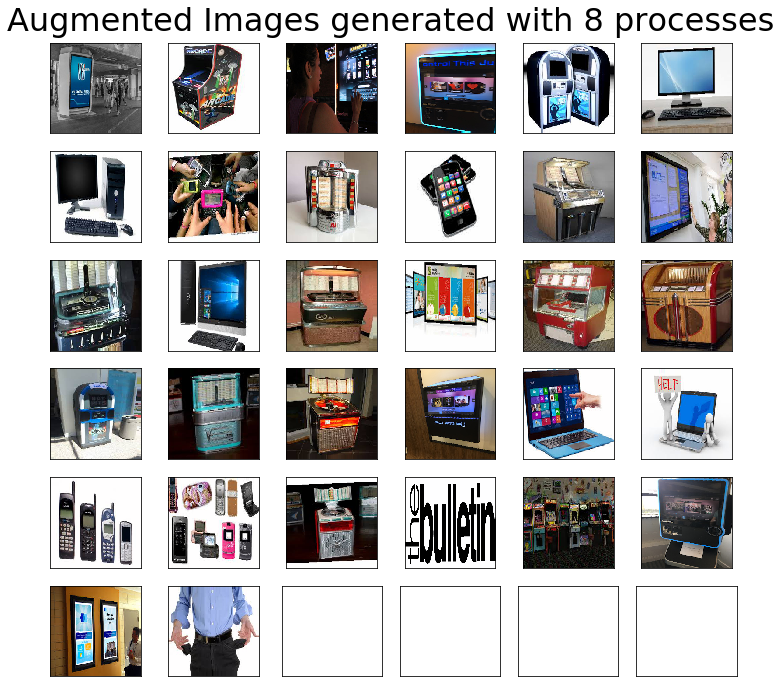

In [8]:
try:
    pool.terminate()
except:
    pass
n_process = 8
    
pool = multiprocessing.Pool(processes=n_process)
start = time.time()
gen = T.ImageDataGenerator(
     shear_range=0.1,
     zoom_range=0.1,
     channel_shift_range=0.1,
     rescale=1/255.,
     pool=pool
)

train_generator = gen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32)

X_train_aug = train_generator.next()

print('{} process, duration: {}'.format(4, time.time() - start))
plot_images(X_train_aug, 'Augmented Images generated with {} processes'.format(n_process))

pool.terminate()

## Fine-Tuning Inception V3

### Setup the Data Generator for Training

In [9]:
pool = None

def init_worker():
    signal.signal(signal.SIGINT, signal.SIG_IGN)

def setup_data_generator(processes=None, batch_size=32):
    global pool, img_width, img_height, train_data_dir, validation_data_dir
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen = T.ImageDataGenerator(
         shear_range=0.1,
         zoom_range=0.1,
         preprocessing_function=preprocess_img,
         pool=pool
    )
    
    testgen = T.ImageDataGenerator(
         preprocessing_function=preprocess_img,
         pool=pool
    )
    
    X_train_aug = gen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

    X_val_aug = testgen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)
    
    return X_train_aug, X_val_aug

### Train The Model On Our Data

In [10]:
n_processes = 8
batch_size = 16
epochs = 25

# Data generators for training and cross-validation
X_train_aug, X_val_aug = setup_data_generator(processes=n_processes, batch_size=batch_size)

# Keras Callbacks 
# https://keras.io/callbacks/#tensorboard
tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs/pretraining', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    './checkpoint.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    period=1)

try:        
    print('Starting training')
    model.fit_generator(
            X_train_aug,
            steps_per_epoch=train_size/batch_size,
            validation_steps=validation_size/batch_size,
            validation_data=X_val_aug,
            epochs=epochs,
            initial_epoch=0,
            verbose=2,
            callbacks=[tensorboard, checkpoint]
    )
except KeyboardInterrupt:
    pass

model.save('inception-pretrain.h5')

Found 494 images belonging to 7 classes.
Found 139 images belonging to 7 classes.
Starting training
Epoch 1/25


KeyboardInterrupt: 

## Deeper Fine-Tuning

To get even better accuracy, we can do a second training run with less frozen layers. Simply initialize the top layer weights with the model that was trained previously.

In [11]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs/training', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    './full-checkpoint.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    period=1)

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

try:        
    print('Starting training')
    model.fit_generator(
            X_train_aug,
            steps_per_epoch=train_size/batch_size,
            validation_steps=validation_size/batch_size,
            validation_data=X_val_aug,
            epochs=50,
            initial_epoch=0,
            verbose=2,
            callbacks=[tensorboard, checkpoint]
    )
except KeyboardInterrupt:
    pass

model.save('inception-full-training.h5')
pool.terminate()

Starting training
Epoch 1/50


## Save The Labels For Re-use

In [12]:
labels = inv_map = {v: k for k, v in train_generator.class_indices.iteritems()}

f = open('./jukebox-classifier-labels.pkl', 'wb')
pickle.dump(labels, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

## Testing the Model

In [13]:
test_model = load_model('inception-full-training.h5')

NB: Good testing should be done on many more images. This is more of a sanity check. 

In [15]:
test_dir = os.path.join('data/test')
files = [x for x in os.listdir(test_dir) if x[0] != '.']
labels = inv_map = {v: k for k, v in train_generator.class_indices.iteritems()}

for f in files: 
    img = load_img(os.path.join(test_dir, f), target_size=(img_width, img_height))
    x_orig = img_to_array(img)
    x = np.expand_dims(x_orig, axis=0)
    x_out = preprocess_input(x)

    classes = test_model.predict(x_out)
    top_c = np.argmax(classes[0])
    print(f, classes[0][top_c], labels[top_c])

('ami.png', 1.0, 'ami')
('arcade.png', 0.86093855, 'touchtunes')
('hooters.png', 0.99940777, 'arcade')
('mobile-juke.png', 0.99998498, 'touchtunes')
('mobile.png', 0.73192972, 'arcade')
('signage.png', 0.99964464, 'touchtunes')
('spotted.jpg', 1.0, 'touchtunes')
('tt.png', 1.0, 'touchtunes')
('with-someone.jpg', 0.99993527, 'arcade')


## Convert the Keras Model to a CoreML Model

In [16]:
coreml_model = coremltools.converters.keras.convert(test_model, 
                                                    input_names='image', 
                                                    image_input_names='image', 
                                                    class_labels=labels.values(),
                                                    output_names='classLabelProbs',
                                                    predicted_probabilities_output='classLabelProbs',
                                                    image_scale=2/255.0,
                                                    red_bias=-1,
                                                    green_bias=-1,
                                                    blue_bias=-1
                                                   )

coreml_model.save('inceptionv3-jukebox.mlmodel')

0 : input_1, <keras.engine.topology.InputLayer object at 0x7f940e4352d0>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7f940e435510>
2 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f940e4354d0>
3 : activation_1, <keras.layers.core.Activation object at 0x7f940e435290>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7f940e435310>
5 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7f940e435350>
6 : activation_2, <keras.layers.core.Activation object at 0x7f940e435390>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7f940e4358d0>
8 : batch_normalization_3, <keras.layers.normalization.BatchNormalization object at 0x7f940e435890>
9 : activation_3, <keras.layers.core.Activation object at 0x7f940e435550>
10 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f940e435590>
11 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7f940e435c10>
12 : batch_normalizat

102 : batch_normalization_35, <keras.layers.normalization.BatchNormalization object at 0x7f94243f0790>
103 : activation_35, <keras.layers.core.Activation object at 0x7f94243f0890>
104 : conv2d_36, <keras.layers.convolutional.Conv2D object at 0x7f94243f09d0>
105 : batch_normalization_36, <keras.layers.normalization.BatchNormalization object at 0x7f94243f0a10>
106 : activation_36, <keras.layers.core.Activation object at 0x7f94243f0b10>
107 : conv2d_32, <keras.layers.convolutional.Conv2D object at 0x7f94243f0c50>
108 : conv2d_37, <keras.layers.convolutional.Conv2D object at 0x7f94243f0c90>
109 : batch_normalization_32, <keras.layers.normalization.BatchNormalization object at 0x7f94243f0d90>
110 : batch_normalization_37, <keras.layers.normalization.BatchNormalization object at 0x7f94243f0e90>
111 : activation_32, <keras.layers.core.Activation object at 0x7f94243f0fd0>
112 : activation_37, <keras.layers.core.Activation object at 0x7f94243fb150>
113 : conv2d_33, <keras.layers.convolutional.C

198 : batch_normalization_65, <keras.layers.normalization.BatchNormalization object at 0x7f941aba2610>
199 : activation_65, <keras.layers.core.Activation object at 0x7f941aba2710>
200 : conv2d_66, <keras.layers.convolutional.Conv2D object at 0x7f941aba2850>
201 : batch_normalization_66, <keras.layers.normalization.BatchNormalization object at 0x7f941aba2890>
202 : activation_66, <keras.layers.core.Activation object at 0x7f941aba2990>
203 : conv2d_62, <keras.layers.convolutional.Conv2D object at 0x7f941aba2ad0>
204 : conv2d_67, <keras.layers.convolutional.Conv2D object at 0x7f941aba2b10>
205 : batch_normalization_62, <keras.layers.normalization.BatchNormalization object at 0x7f941aba2c10>
206 : batch_normalization_67, <keras.layers.normalization.BatchNormalization object at 0x7f941aba2d10>
207 : activation_62, <keras.layers.core.Activation object at 0x7f941aba2e50>
208 : activation_67, <keras.layers.core.Activation object at 0x7f941aba2f90>
209 : conv2d_63, <keras.layers.convolutional.C

295 : batch_normalization_88, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c5490>
296 : batch_normalization_89, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c5590>
297 : batch_normalization_92, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c56d0>
298 : batch_normalization_93, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c5810>
299 : conv2d_94, <keras.layers.convolutional.Conv2D object at 0x7f941d2c5950>
300 : batch_normalization_86, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c5a90>
301 : activation_88, <keras.layers.core.Activation object at 0x7f941d2c5b90>
302 : activation_89, <keras.layers.core.Activation object at 0x7f941d2c5cd0>
303 : activation_92, <keras.layers.core.Activation object at 0x7f941d2c5d10>
304 : activation_93, <keras.layers.core.Activation object at 0x7f941d2c5d50>
305 : batch_normalization_94, <keras.layers.normalization.BatchNormalization object at 0x7f941d2c5d